# 0.0 Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1 Funções auxiliares

In [2]:
def cramer_v (x, y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm )[0]
    chi2corr = max (0, chi2 - (k-1)*(r-1) / (n-1) )
    
    kcorr = k - (k-1)**2/ (n-1)
    rcorr = r - (r-1)**2/ (n-1)
    
    return np.sqrt( (chi2corr/n) / (min( kcorr-1 , rcorr-1 ) ) )

def mean_absolute_percentage_error( y, yhat):
    return np.mean(  np.abs ( ( y - yhat ) / y ) )

def m1_error ( model_name,y, yhat):
    mae = mean_absolute_error (y , yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt ( mean_squared_error (y, yhat))
    
    return pd.DataFrame( { 'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE': rmse }, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range ( 1, kfold+1) ):
        #começo e final para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta( days= k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days= (k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training [ ( x_training['date']  >= validation_start_date ) & ( x_training['date']  <= validation_end_date ) ]

        #treinamento
        xtraining = training.drop(['date','sales'],axis =1)
        ytraining = training['sales']

        #validacao
        yvalidation = validation['sales']
        xvalidation = validation.drop(['date','sales'],axis = 1)

        #modelo
        m = model.fit(xtraining, ytraining)

        #predicao
        yhat = m.predict(xvalidation)

        #perfomance
        m_result = m1_error (model_name, np.expm1(yvalidation), np.expm1(yhat))

        #perfomance por loja por k iteracoes
        mae_list.append (m_result['MAE'] )
        mape_list.append (m_result['MAPE'] )
        rmse_list.append ( m_result['RMSE'] )
        if verbose:
            print(lr_result)

    return pd.DataFrame( {'Model Name': model_name,
         'MAE CV': np.round( np.mean(mae_list), 2 ).astype(str) + ' +/- ' + np.round (np.std (mae_list), 2).astype(str),
         'MAPE CV': np.round( np.mean(mape_list), 2 ).astype(str) + ' +/- ' + np.round (np.std (mape_list), 2).astype(str),
         'RMSE CV': np.round( np.mean(rmse_list), 2 ).astype(str) + ' +/- ' + np.round (np.std (rmse_list), 2).astype(str) } , index=[0])


# 1.0 Carregando os dados

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory= False)
df_store_raw = pd.read_csv('data/store.csv', low_memory= False)


#merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 2.0 Descrição dos dados

In [4]:
df1 = df_raw.copy()

## 2.1 Renomear colunas

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday',
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old) )

#renomear
df1.columns = cols_new

## 2.2 Dimensão dos dados

In [6]:
print( 'Number of Rows:{}'.format( df1.shape[0]))
print( 'Number of Cols:{}'.format( df1.shape[1]))

Number of Rows:1017209
Number of Cols:18


## 2.3 Tipo de dados

In [7]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 verificar os NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2.5 preencher os NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance              2642
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan ( x ) else x )

#competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else
                                                x['competition_open_since_month'], axis =1)

#competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else
                                                x['competition_open_since_year'], axis =1)
#promo2                               0
#promo2_since_week               508031
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].month if math.isnan( x['promo2_since_week']) else
                                                x['promo2_since_week'], axis =1)
#promo2_since_year               508031
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else
                                                x['promo2_since_year'], axis =1)

#promo_interval                  508031
month_map = {1:'Jan',2:'fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
#substituir NA por 0
df1['promo_interval'].fillna(0, inplace=True)
#transaformando data em mes
df1['month_map'] = df1['date'].dt.month.map(month_map)
#verificando se a loja fez parte da promocao
df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                            if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 2.6 Alterar Tipos

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = np.int64 ( df1['competition_open_since_month'] )
df1['competition_open_since_year'] = np.int64 ( df1['competition_open_since_year'] )
df1['promo2_since_week'] = np.int64 ( df1['promo2_since_week'] )
df1['promo2_since_year'] = np.int64 ( df1['promo2_since_year'] )

## 2.7 Descrição Estatística

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'])

## 2.7.1 Atributes Numericos

In [15]:
#Tendencia Central - media , mediana
ct1 = pd.DataFrame ( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame ( num_attributes.apply( np.median ) ).T

# Dispersão - std , max ,range , skew , kurtosis
d1 = pd.DataFrame ( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply( lambda x: x.kurtosis() - x.min() ) ).T

#concatenar
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ( ['attributes','min','max','range','mean','median','std','skew','kurtosis'])

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-2.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-2.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,127.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-2.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,-1775.928696


C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

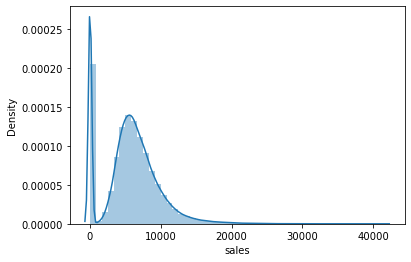

In [17]:
#verificar a distribuição das vendas
sns.distplot( df1['sales'])

C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

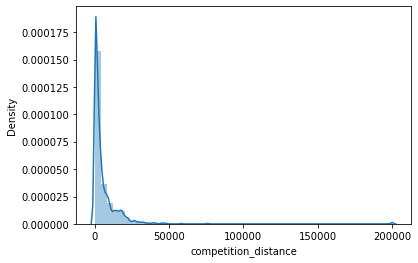

In [18]:
#verificar a distribuição dos competidores
sns.distplot( df1['competition_distance'])

## 2.7.2 Atributos Categóricas

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

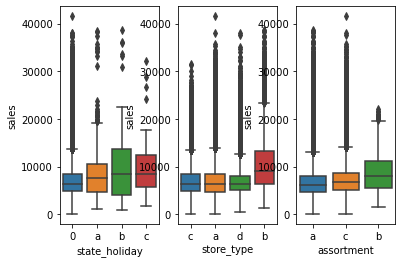

In [20]:
#eliminar dias 0 de venda(lojas fechadas)
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0 )]

#plotar distirbuição de varaveis categoricas
plt.subplot (1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot (1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot (1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 3.0 Feature Engineering

In [21]:
df2 = df1.copy()

## 3.1 Mapa mental de hipóteses

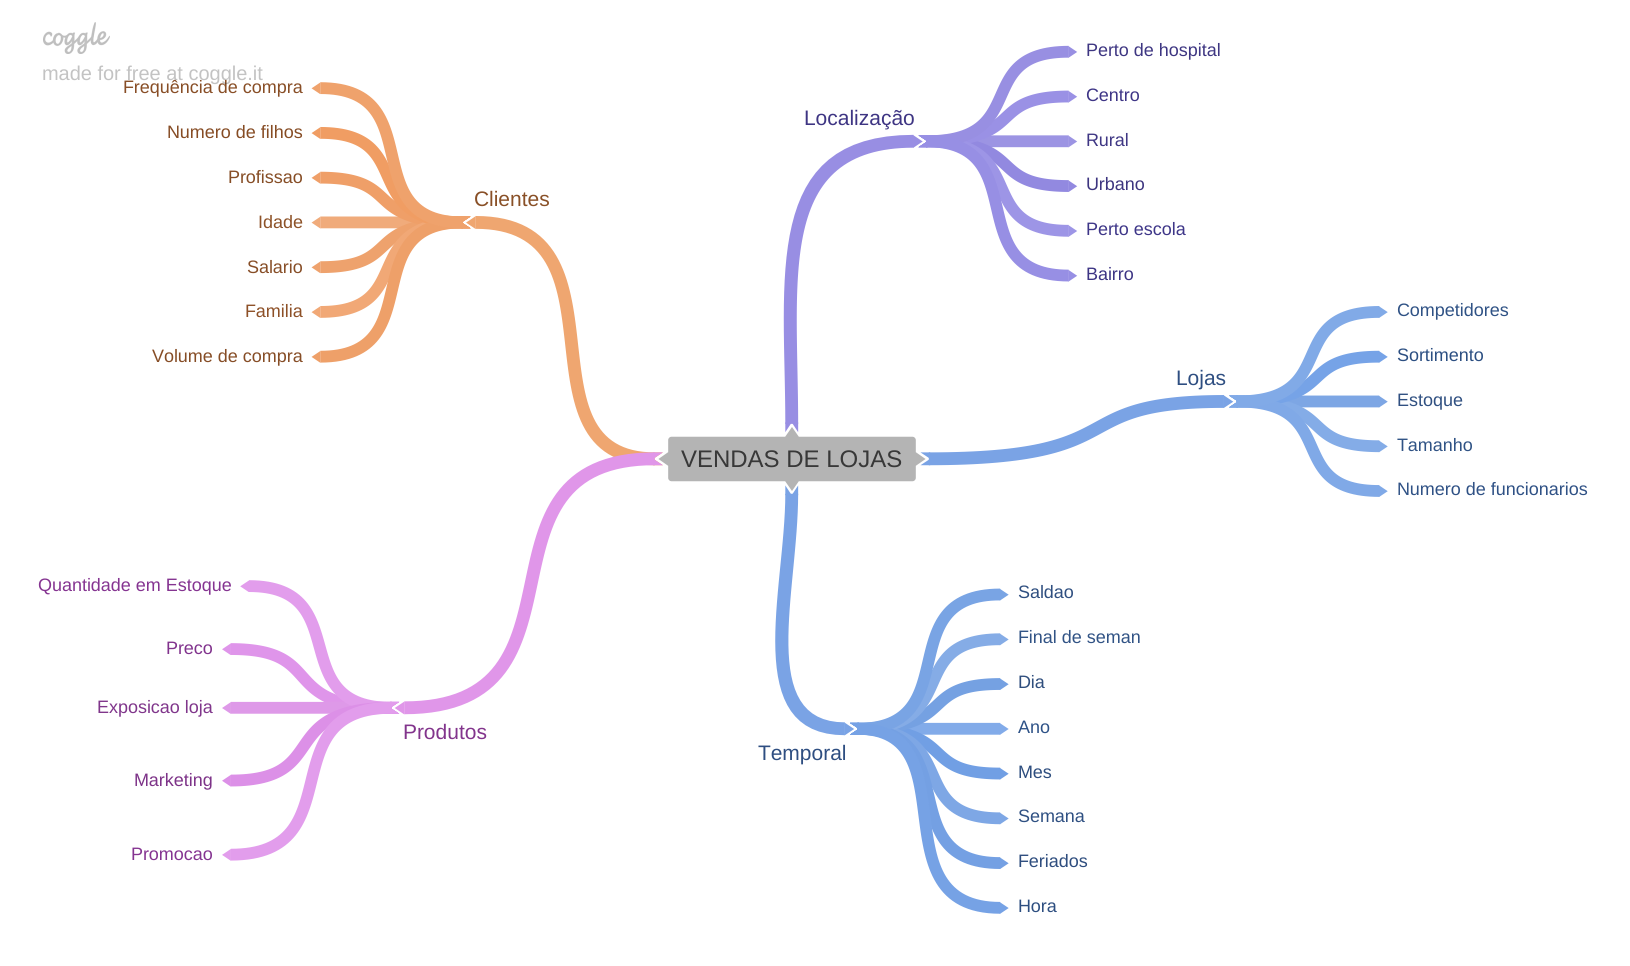

In [22]:
Image( 'img/VENDAS_DE_LOJAS.png')

## 3.2 criação das hipoteses

### 3.2.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais perto deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 3.2.2 Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que espoem mais o produto nas vistrines deveriam vender mais

**3.** Lojas que tem preços menores deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com promoções mais agrresivas (descontos maiores) deveriam vender mais

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais

**7.** Lojas com maior dias de promoção deveriam vender mais

**8.** Lojas com mais promoções consecutivas deveriam vender mais

### 3.2.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado dde natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mÊs

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durantes os feriados escolares

## 3.2 Lista Final de Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais perto deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com maior dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**8.** Lojas abertas durante o feriado dde natal deveriam vender mais

**9.** Lojas deveriam vender mais ao longo dos anos

**10.** Lojas deveriam vender mais no segundo semestre do ano

**11.** Lojas deveriam vender mais depois do dia 10 de cada mÊs

**12.** Lojas deveriam vender menos aos finais de semana

**13.** Lojas deveriam vender menos durantes os feriados escolares

## 3.3 Feature Engineering

In [23]:
df1['competition_open_since_year'].unique()

array([2008, 2007, 2006, 2009, 2015, 2013, 2014, 2000, 2011, 2010, 2005,
       1999, 2003, 2012, 2004, 2002, 1961, 1995, 2001, 1990, 1994, 1900,
       1998], dtype=int64)

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of yeardf2['year'] = df2['date'].dt.year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since juntar colunas para formar data
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month=x['competition_open_since_month'], day=1), axis=1 )
                                
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'])/ 30 ).apply( lambda x: x.days).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) /7).apply( lambda x: x.days).astype( int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

C:\Users\claud\AppData\Local\Temp/ipykernel_3408/59108560.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 4.0 Passo 4 - Filtragem de Variáveis

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-02-09,24
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-02-09,24
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-02-09,24


## 4.1 - Filtragem das Linhas

In [28]:
df3 = df3[ (df3['open'] != 0 ) &  (df3['sales'] > 0) ]

## 4.2 - Seleção das Colunas

In [29]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 5.0 - Análise exploratória dos daddos

In [31]:
df4 = df3.copy()

## 5.1 - Análise Univariada

### 5.1.1 - Response Variable

C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

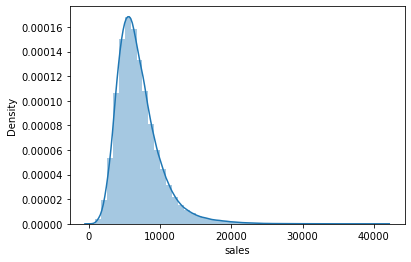

In [32]:
sns.distplot (df4['sales'])

### 5.1.2 - Numerical Variable

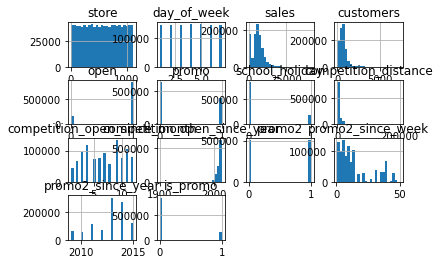

In [33]:
num_attributes.hist(bins=25);

### 5.1.3 - Categorical Variable

In [34]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

<AxesSubplot:xlabel='sales', ylabel='Density'>

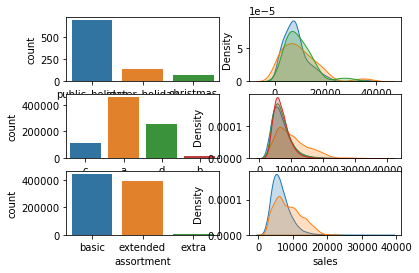

In [35]:
#state_hgoliday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday']!= 'regular_day']
sns.countplot( a['state_holiday'] )
    
plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holidday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holidday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

#store_type
plt.subplot(3, 2, 3)
sns.countplot( df4['store_type'] )
    
plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

#assortment
plt.subplot(3, 2, 5)
sns.countplot( df4['assortment'] )
    
plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'extends']['sales'], label='extends', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 5.2 - Analise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais

**FALSA** - lojas com mais sortimento vendem menos

<AxesSubplot:xlabel='year_week'>

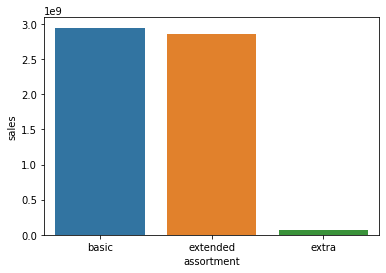

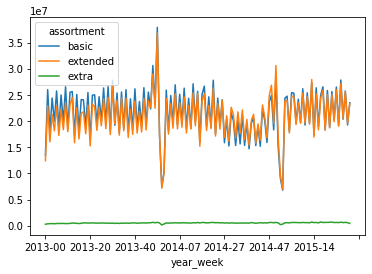

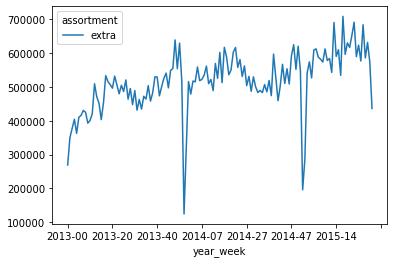

In [36]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()



### **H2.** Lojas com competidores mais perto deveriam vender menos.

**FALSA** Lojas com competidores mais proximos vendem mais

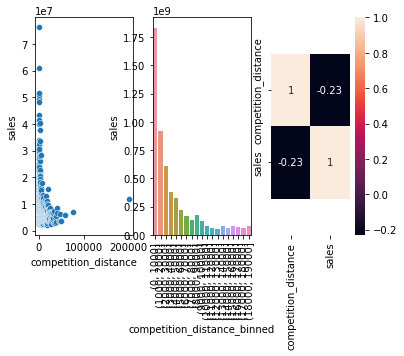

In [37]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3 , 1)
sns.scatterplot (x= 'competition_distance', y='sales', data = aux1 ) ;

plt.subplot(1, 3 , 2)
bins= list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x= 'competition_distance_binned',y='sales', data=aux2);
plt.xticks ( rotation=90);

plt.subplot(1, 3 , 3)
x = sns.heatmap(aux1.corr( method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim ( bottom+0.5, top-0.5);

### **3H.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSO**  lojas com competidores a mais tempo vendem menos

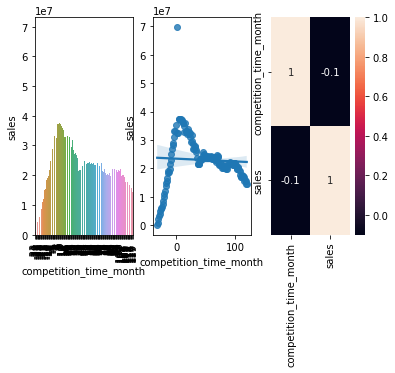

In [38]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month').sum().reset_index()
aux2 = aux1[ ( aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x = 'competition_time_month', y='sales', data=aux2);
plt.xticks ( rotation= 90);

plt.subplot(1,3,2)
sns.regplot( x ='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top+0.5);

### **H8.** Lojas abertas durante o feriado dde natal deveriam vender mais
**FALSA** Lojas abertas durante o feriado de natal vendem menos

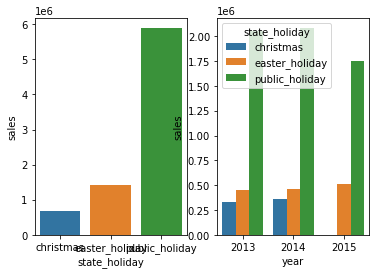

In [39]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year','state_holiday','sales']].groupby( ['year','state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales',hue='state_holiday', data=aux2);

### **H9.** Lojas deveriam vender mais ao longo dos anos

**FALSA** Lojas vencem menos ao longo dos anos

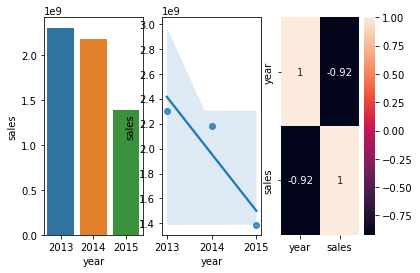

In [40]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='year',y='sales', data=aux1);

plt.subplot( 1, 3, 2)
sns.regplot( x='year',y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem menos no segundo semestre do ano

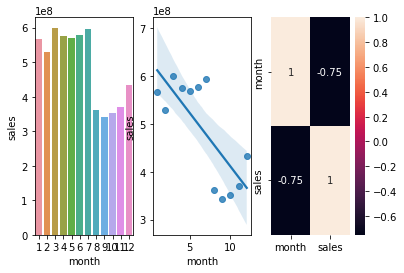

In [41]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='month',y='sales', data=aux1);

plt.subplot( 1, 3, 2)
sns.regplot( x='month',y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mÊs
**VERDADEIRA**  Lojas vendem mais depois do dia 10

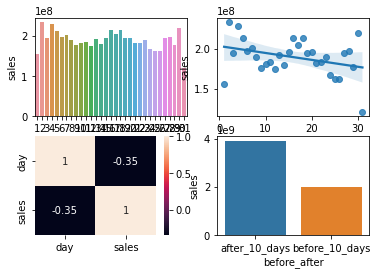

In [42]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot( x='day',y='sales', data=aux1);

plt.subplot( 2, 2, 2)
sns.regplot( x='day',y='sales', data=aux1);

plt.subplot( 2, 2, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2, 2, 4)
sns.barplot( x= 'before_after', y='sales', data=aux2);

### **H12.** Lojas deveriam vender menos aos finais de semana##
**VERDADEIRA** Lojas vendem menos nos finais de semana

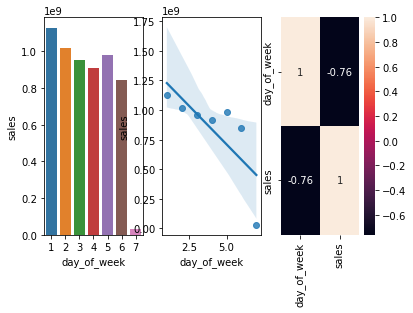

In [43]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='day_of_week',y='sales', data=aux1);

plt.subplot( 1, 3, 2)
sns.regplot( x='day_of_week',y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H13.** Lojas deveriam vender menos durantes os feriados escolares
**VERDADEIRO** Lojas vendem menos durante os feriados escolares , exceto os meses de julho de agosto

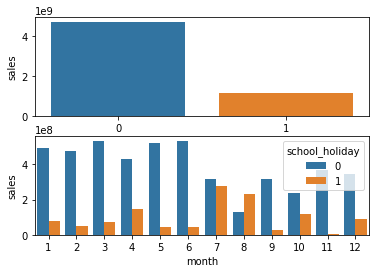

In [44]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot( 2, 1, 1)
sns.barplot( x='school_holiday',y='sales', data=aux1);


aux2 = df4[['month', 'school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot( 2, 1, 2)
sns.barplot( x='month',y='sales',hue='school_holiday', data=aux2);



## 5.3 - Análise Multivariada

### 5.3.1. Numerical Attributes

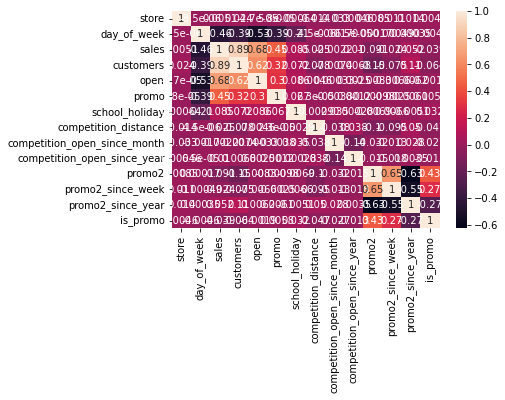

In [45]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap( correlation, annot=True);

### 5.3.2 Categorical Attributes

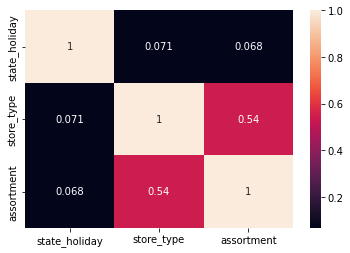

In [46]:
#somente dados categoricos
a = df4.select_dtypes( include='object')

#calclular v de cramer
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#dataset final
d = pd.DataFrame( {'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]
              })

d = d.set_index( d.columns )

sns.heatmap( d, annot= True);

# 6.0 - Preparação de Dados

In [47]:
df5 = df4.copy()

## 6.1 - Normalização

## 6.2 - Rescaling

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()

#competiiton distance
df5['competition_distance'] = rs.fit_transform (df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform (df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform (df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform (df5[['year']].values)

## 6.3 - Transformacao

### 6.3.1 Encoding

In [49]:
#state_hholidat - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encodig
le = LabelEncoder()
df5['store_type'] = le.fit_transform (df5['store_type'])

#assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                  'extra': 2 ,
                  'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict)

In [50]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-02-09,0.341686,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-02-09,0.341686,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-02-09,0.341686,0,0,0,1


### 6.3.2 - Transformação da variavel resposta

In [51]:
df5['sales'] = np.log1p( df5['sales'])


C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

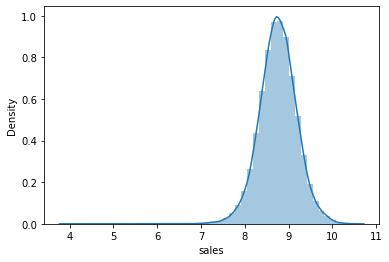

In [52]:
sns.distplot (df5['sales'])

### 6.3. - Transformação de natureza

In [53]:
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply (lambda x: np.sin (x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply (lambda x: np.cos (x * (2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply (lambda x: np.sin (x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply (lambda x: np.cos (x * (2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply (lambda x: np.sin (x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply (lambda x: np.cos (x * (2. * np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply (lambda x: np.sin (x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply (lambda x: np.cos (x * (2. * np.pi/52)))

In [54]:
df5.head(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
5,6,5,2015-07-31,8.639765,1,1,0,1,-0.325806,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
6,7,5,2015-07-31,9.638545,1,1,0,3,3.495161,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
7,8,5,2015-07-31,9.046998,1,1,0,1,0.837097,10,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
8,9,5,2015-07-31,9.055556,1,1,0,3,-0.048387,8,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
9,10,5,2015-07-31,8.879890,1,1,0,1,0.133871,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 7.0 - Selecão de variaveis(colunas)

In [55]:
df6 = df5.copy()


## 7.1 - Dividir dataframe em treino e teste

In [56]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop( cols_drop, axis=1)

In [57]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [58]:
#dataset treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#dataset test
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format(X_train['date'].min() ))
print( 'Training Min Date: {}'.format(X_train['date'].max() ))

print( '\nTest Min Date: {}'.format(X_test['date'].min() ))
print( 'Test Min Date: {}'.format(X_test['date'].max() ))

Training Min Date: 2013-01-01 00:00:00
Training Min Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


In [59]:
X_train

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.000000,-0.587785,-0.809017,0.120537,-0.992709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2013-01-01,8.124447,0,1,1,1,-0.351613,9,2006,...,1,0,0.974928,-0.222521,5.000000e-01,0.866025,0.207912,0.978148,0.120537,0.992709
1016827,733,2013-01-01,9.284148,0,1,1,2,-0.237097,10,1999,...,1,0,0.974928,-0.222521,5.000000e-01,0.866025,0.207912,0.978148,0.120537,0.992709
1016863,769,2013-01-01,8.524367,0,1,1,2,-0.240323,1,2013,...,1,0,0.974928,-0.222521,5.000000e-01,0.866025,0.207912,0.978148,0.120537,0.992709
1017042,948,2013-01-01,8.410053,0,1,1,2,-0.145161,1,2013,...,1,0,0.974928,-0.222521,5.000000e-01,0.866025,0.207912,0.978148,0.120537,0.992709


## 7.2 - Implementando o Boruta

In [60]:
#treino e test para o boruta
X_train_n = X_train.drop(['date','sales'],axis = 1).values
y_train_n = y_train.values.ravel()

#definicao random forest 
rf = RandomForestRegressor( n_jobs=-1)

#definicao Boruta

#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

### 7.2.1 - melhores colunas selecionadas pelo boruta

In [61]:
#cols_selected = boruta.support_.tolist()

# melhores colunas
#X_train_fs = X_train.drop(['date','sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#colunas não selecioandzs pelo borura
#cols_not_selected_boruta = list (np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 7.3 - Seleção manual de colunas

In [73]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
'week_of_year_sin',
 'week_of_year_cos']


# adicionar colunas
feat_to_add = ['date','sales']

#coluna final
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add)


# 8.0 - Modelos de Machine Learning

In [63]:
x_train = X_train[ cols_selected_boruta]
x_test = X_test[ cols_selected_boruta]

## 8.1 - Modelo de média

In [64]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#predicao
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename( columns={'sales':'predictions'})
aux1 = pd.merge( aux1, aux2, how ='left', on='store')
yhat_baseline = aux1['predictions']

#perfomance
baseline_result = m1_error('Avarage Model', np.expm1 (y_test), np.expm1 (yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.455051,1835.135542


## 8.2 - Modelo de regressão linear

In [65]:
#modelo
lr = LinearRegression().fit(x_train, y_train)

#predicao
yhat_lr = lr.predict( x_test)

#perfomance
lr_result = m1_error( 'Linear Regression', np.expm1( y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.999225,0.294903,2665.742106


### 8.2.1  - Cross Validation Lineqar Regression Model

In [134]:
lr_result_cv =  cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2094.24 +/- 301.77,0.3 +/- 0.02,2963.5 +/- 486.08


## 8.3 Modelo de regressão linear Regularizado - Lasso

In [66]:
#modelo
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#predicao
yhat_lrr = lrr.predict( x_test)

#perfomance
lrr_result = m1_error( 'Linear Regression - Lasso', np.expm1( y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1894.725095,0.288322,2756.092763


### 8.3.1 - Cross Validation Lasso

In [135]:
lrr_result_cv =  cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2122.84 +/- 364.56,0.29 +/- 0.01,3059.41 +/- 543.84


## 8.4 - Regressão Random Forest

In [67]:
#modelo
rf =RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state = 42).fit(x_train, y_train)

#predicao
yhat_rf = rf.predict( x_test)

#perfomance
rf_result = m1_error( 'Random Forest Regressor', np.expm1( y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,665.347641,0.097968,993.146934


### 8.4.1 - Cross Validation - Random Forest 

In [136]:
rf_result_cv =  cross_validation(x_training, 5, 'Random Forest', rf, verbose = False)
rf_result_cv 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,841.13 +/- 235.66,0.12 +/- 0.03,1258.47 +/- 348.44


## 8.5 -  XGBOost Regressor

In [145]:
#modelo
model_xgb = xgb.XGBRegressor (objective='reg:squarederror',
                              n_estimators =100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit(x_train, y_train)
#predicao
yhat_xgb = model_xgb.predict( x_test)

#perfomance
xgb_result = m1_error( 'XGBoost Regressor', np.expm1( y_test), np.expm1(yhat_xgb))
xgb_result

C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.488784,0.949471,7330.595131


### 8.5.1 - Cross Validation - XGBoost

In [142]:
xgb_result_cv =  cross_validation(x_training, 5, 'XGboost Regressor', model_xgb, verbose = True)
xgb_result_cv 

C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1980.557204  0.284178  2838.276678


C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1980.557204  0.284178  2838.276678


C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1980.557204  0.284178  2838.276678


C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1980.557204  0.284178  2838.276678


C:\Users\claud\anaconda3\envs\ds_em_producao\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1980.557204  0.284178  2838.276678


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGboost Regressor,7049.11 +/- 588.66,0.95 +/- 0.0,7714.95 +/- 689.71


## 8.6 - Comparativo de perfomance entre os modelos

### 8.6.1 - Perfomance simples

In [143]:
modelling_result = pd.concat( [baseline_result,lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,665.347641,0.097968,993.146934
0,Avarage Model,1354.800353,0.455051,1835.135542
0,Linear Regression - Lasso,1894.725095,0.288322,2756.092763
0,Linear Regression,1980.557204,0.284178,2838.276678
0,XGBoost Regressor,6683.488784,0.949471,7330.595131


### 8.6.2 -  Perfomance Real - Cross Validation

In [144]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2094.24 +/- 301.77,0.3 +/- 0.02,2963.5 +/- 486.08
0,Lasso,2122.84 +/- 364.56,0.29 +/- 0.01,3059.41 +/- 543.84
0,Random Forest,841.13 +/- 235.66,0.12 +/- 0.03,1258.47 +/- 348.44
0,XGboost Regressor,7049.11 +/- 588.66,0.95 +/- 0.0,7714.95 +/- 689.71


## 8.7 - Cross Validation

In [129]:
model = Lasso(alpha=0.01)
a = cross_validation(x_training, 5 ,'Lasso', model)
a

In [131]:
model = LinearRegression()
a = cross_validation(x_training, 5 ,'Regressao Linear', model, verbose=True)
a

          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1980.557204  0.284178  2838.276678
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1980.557204  0.284178  2838.276678
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1980.557204  0.284178  2838.276678
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1980.557204  0.284178  2838.276678
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1980.557204  0.284178  2838.276678
